In [1]:
import subprocess
import math
import sys
import argparse #https://docs.python.org/2/library/argparse.html
import json
import time
import datetime
import os
import re
import nibabel as nib
import numpy as np
import urllib, json
import requests
import pandas as pd
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import glob
import nibabel as nib
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle
dpi_default = mpl.rcParams['figure.dpi']
from IPython.display import clear_output
def bash_run(command):

        proc = subprocess.Popen(['/bin/bash'],text=True ,stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        return proc.communicate(command) , (proc.returncode == 0)
#http://www.marmosetbrain.org/api/v1/injections

from collections import OrderedDict
def json_read(filename):
        if (os.path.isfile(filename)):
            with open(filename) as data_file:
                data = json.load(data_file, object_pairs_hook=OrderedDict)
            isfile=True;
        else:
            data={}
            isfile=False;
        return data, isfile    
    
def json_write(data,filename):
        with open(filename, 'w') as data_file:
            json.dump(data, data_file, indent=4, sort_keys=False, separators=(',', ':'))

We provide the script that we used to import and map the Marmoset Brain Connectivity Atlas
(Marmoset_Brain_Connectivity_Atlas_import.ipynb). We also provide intermediate resuls as a pickle 
file in our BMCR data repository (inj.p in inj_auxiliary_data)

In [10]:
# path to inj.p
OUT_data =  '.../inj.p'
PATH_TO_BMCR_data = '...'

In [4]:
fn_a = PATH_TO_BMCR_data+'BMCR_img_data/'
fn_r = PATH_TO_BMCR_data+'/Imported_retrograde_tracer_data_Marmoset_Brain_Connectivity_Atlas/'


inj_sites_fmstack_a = glob.glob(fn_a+"*")
positions_std_a = []
rid_a = []
mids = []

for i in inj_sites_fmstack_a:
    #clear_output(wait=True)
    mids += [i.split("/")[-1].split("-")[1]]
    rid_a += [i.split("/")[-1].split("-")[0]]
    mid = i.split("/")[-1]#.split("-")[1]
    
    inj_s_cells = fn_a+mid+'/meta/anterograde_cell_locations_vox.csv'
    file = pd.read_csv(inj_s_cells, header=None) 
    positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float32).mean(axis=0)
    positions_std_a += [positions_std]
    
positions_std_a = np.array(positions_std_a)


all_cells_loaded = pickle.load( open( OUT_data, "rb" ) )
positions_std_r = []

mids_r = []
rid_r = []

for key in all_cells_loaded["injection_site"]:
    mid = all_cells_loaded["injection_site"][key]["meta"]["id"]
    
    i = fn_r +"/flatmap_stacks_MBM/"+mid+"_l_inj.nii.gz"
    if os.path.isfile(i):
        positions_std_r += [all_cells_loaded["injection_site"][key]['injection_site']]
        mids_r += [mid]
        rid_r +=  [all_cells_loaded["injection_site"][key]['meta']['area']] 
        #break
positions_std_r = np.array(positions_std_r)

In [ ]:

fn_a = PATH_TO_BMCR_data+'/BMCR_img_data/'
inj_sites_fmstack_a = glob.glob(fn_a+"*")
files_retra = []
files_retra_area = []
files_a = []
files_ai = []
for i in inj_sites_fmstack_a:
    clear_output(wait=True)
    print(i)
    files_retra_area += [i.split("/")[-1].split("-")[0]]
    files_retra += [i+"/flatmaps_stacks/MBM/anterograde_tracer_positive_voxels_l.nii.gz"]
    tmp = nib.load(i+"/flatmaps_stacks/MBM/anterograde_tracer_positive_voxels_l.nii.gz").get_fdata()
    
    tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
    tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
    
    files_a += [tmp]
    
    tmp = nib.load(i+"/flatmaps_stacks/MBM/anterograde_cell_density_l.nii.gz").get_fdata()
    
    tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
    tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
    
    files_ai += [tmp]   


In [ ]:
all_cells_loaded = pickle.load( open( OUT_data, "rb" ) )
fn_r = PATH_TO_BMCR_data+'/Imported_retrograde_tracer_data_Marmoset_Brain_Connectivity_Atlas/'


files_retro = []
files_retro_area = []
files_r = []
files_ri = []

for key in all_cells_loaded["injection_site"]:
    mid = all_cells_loaded["injection_site"][key]["meta"]["id"]
    i = fn_r +"/flatmap_stacks_MBM/"+mid+"_l_inj.nii.gz"
    if os.path.isfile(i):
        clear_output(wait=True)
        print(i)
        ff = i
        files_retro += [i]
        files_retro_area += [all_cells_loaded["injection_site"][key]["meta"]["area"]]
        tmp = nib.load(ff).get_fdata()
        tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
        files_ri += [tmp]

        ff = i.replace("_inj.nii.gz",".nii.gz")
        tmp = nib.load(ff).get_fdata()
        tmp = (tmp[::2,::2,:] + tmp[1::2,1::2,:] + tmp[1::2,::2,:] + tmp[::2,1::2,:])/4.0
        files_r += [tmp]



In [14]:
distmat = lambda a,b: np.maximum(-2*(np.matmul(a,b.transpose())) + np.sum(a**2,axis=1).transpose()[:,None]+ np.sum(b**2,axis=1).transpose()[None,:],0)
cmati = distmat(positions_std_a.astype(np.float64),positions_std_r.astype(np.float64))
best_retro = cmati.argmin(axis=1)
best_score = cmati.min(axis=1)


In [15]:
rsort = np.argsort(rid_a)
cmat_aa = np.zeros([len(best_retro),len(best_retro)])
cmat_ar = np.zeros([len(best_retro),len(best_retro)])
cmat_rr = np.zeros([len(best_retro),len(best_retro)])
for a in range(len(best_retro)):
    sa = files_a[rsort[a]]
    sr2 = files_r[best_retro[rsort[a]]]
    for r in range(len(best_retro)):
        sa2 = files_a[rsort[r]]
        sr = files_r[best_retro[rsort[r]]]

        cmat_ar[a,r] = np.sum(sa/np.sqrt(np.sum(sa**2))*sr/np.sqrt(np.sum(sr**2)))
        cmat_aa[a,r] = np.sum(sa/np.sqrt(np.sum(sa**2))*sa2/np.sqrt(np.sum(sa2**2)))
        cmat_rr[a,r] = np.sum(sr2/np.sqrt(np.sum(sr2**2))*sr/np.sqrt(np.sum(sr**2)))


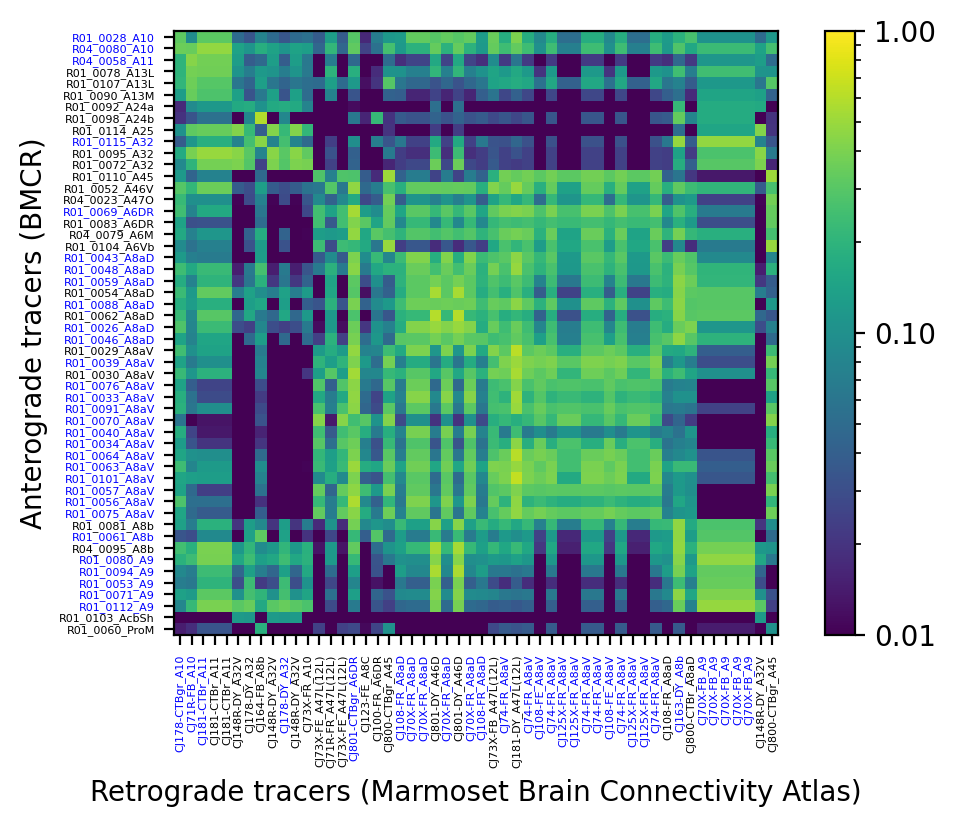

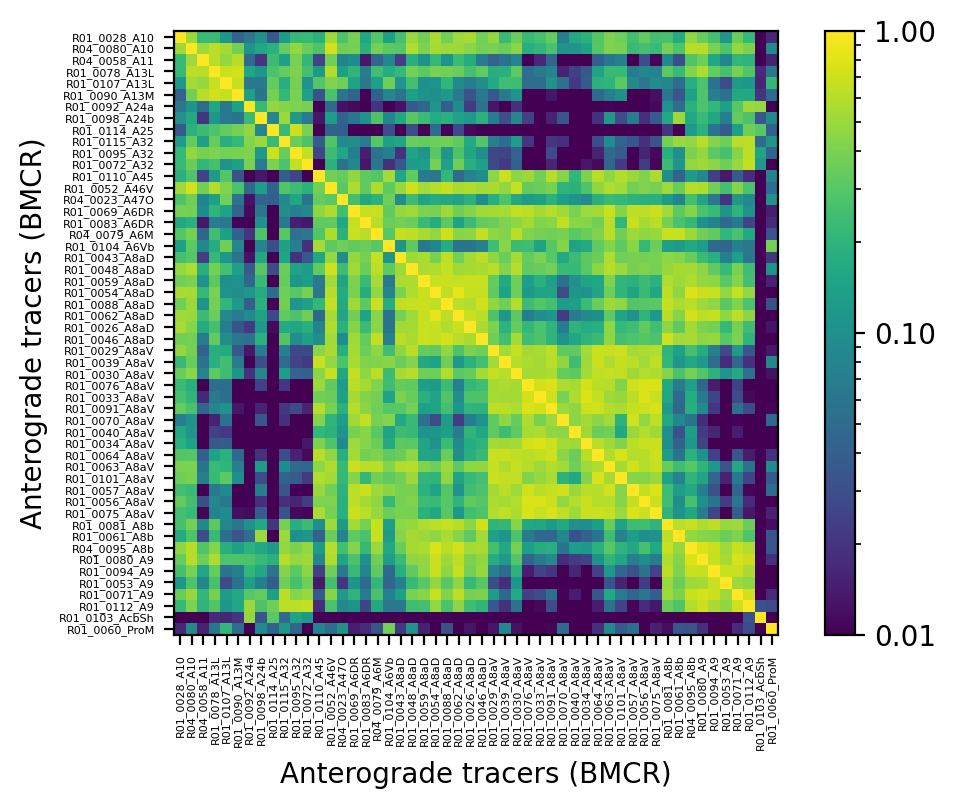

In [21]:

mpl.rcParams['figure.dpi'] = 200
f = plt.figure()
ax = f.gca()

im = ax.imshow(cmat_ar, norm=LogNorm(vmin=0.01, vmax=1))

ax.set_ylabel("Anterograde tracers (BMCR)")
ax.set_xlabel("Retrograde tracers (Marmoset Brain Connectivity Atlas)")



labels_x = [mids_r[best_retro[rsort[a]]]+"_"+rid_r[best_retro[rsort[a]]] for a in range(len(mids))]
ax.set_xticks(ticks=np.arange(cmat_ar.shape[0]), labels=labels_x,rotation = 90, fontsize=4)

labels_y = [mids[rsort[a]]+"_"+rid_a[rsort[a]] for a in range(len(mids))]
ax.set_yticks(ticks=np.arange(cmat_ar.shape[0]), labels=labels_y, fontsize=4)

for xticklabel,yticklabel,lx, ly in zip(ax.get_xticklabels(),ax.get_yticklabels(),labels_x,labels_y):
    llx = lx.split("_")[-1]
    lly = ly.split("_")[-1]
    #print(ticklabel)
    if llx == lly:
        xticklabel.set_color("b")
        yticklabel.set_color("b")
    else:
        xticklabel.set_color("k")
        yticklabel.set_color("k")

fmt = lambda x, pos: '{:.2f}'.format(x)
f.colorbar(im,ax=ax,format=FuncFormatter(fmt))
f.show()
f.savefig('BMCR_Figures/Fig07/BMCR_vs_MBCA_best_choice_by_point_distance_NCC_logplot.pdf',bbox_inches='tight')  

f = plt.figure()
ax = f.gca()

ax.imshow(cmat_aa, norm=LogNorm(vmin=0.01, vmax=1))

ax.set_xlabel("Anterograde tracers (BMCR)")
ax.set_ylabel("Anterograde tracers (BMCR)")


labels_x = [mids[rsort[a]]+"_"+rid_a[rsort[a]] for a in range(len(mids))]
ax.set_xticks(ticks=np.arange(cmat_ar.shape[0]), labels=labels_x,rotation = 90, fontsize=4)
#labels_y = [mids_r[best_retro[rsort[a]]]+"_"+rid_r[best_retro[rsort[a]]] for a in range(len(mids))]
ax.set_yticks(ticks=np.arange(cmat_ar.shape[0]), labels=labels_x, fontsize=4)
f.colorbar(im,ax=ax,format=FuncFormatter(fmt))
f.show()
f.savefig('BMCR_Figures/Fig07/BMCR_vs_BMCA_as_reference_NNC_logplot.pdf',bbox_inches='tight')  

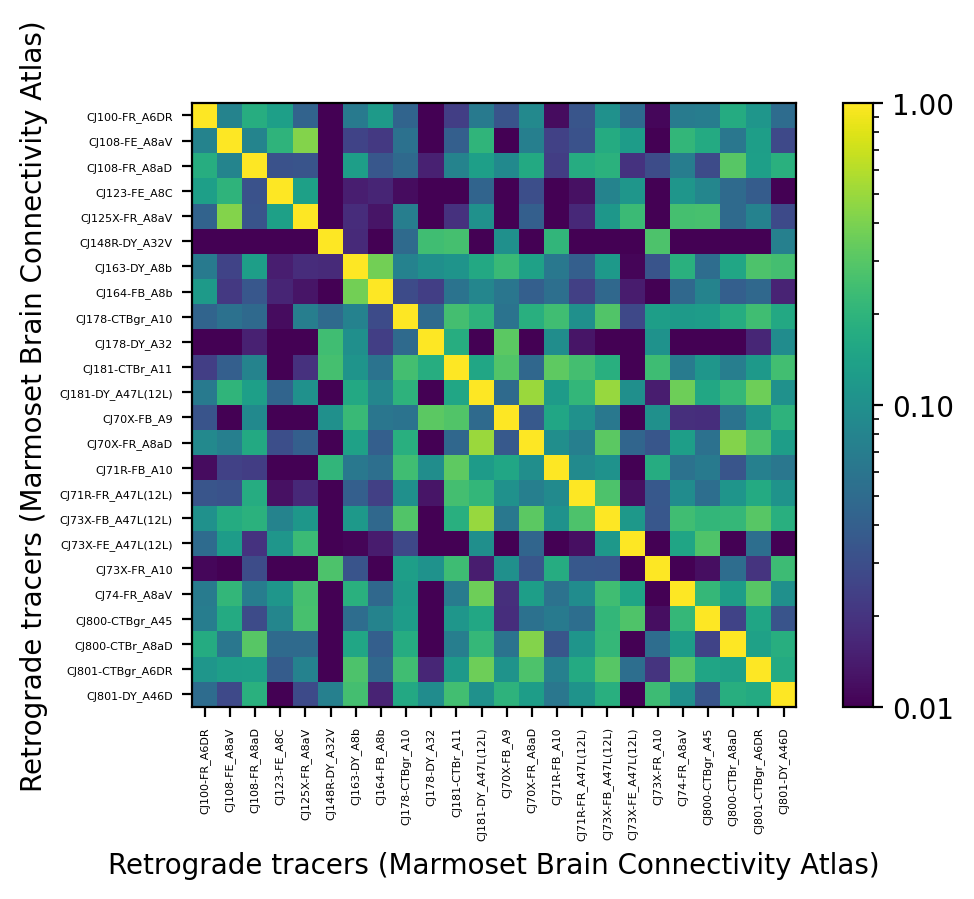

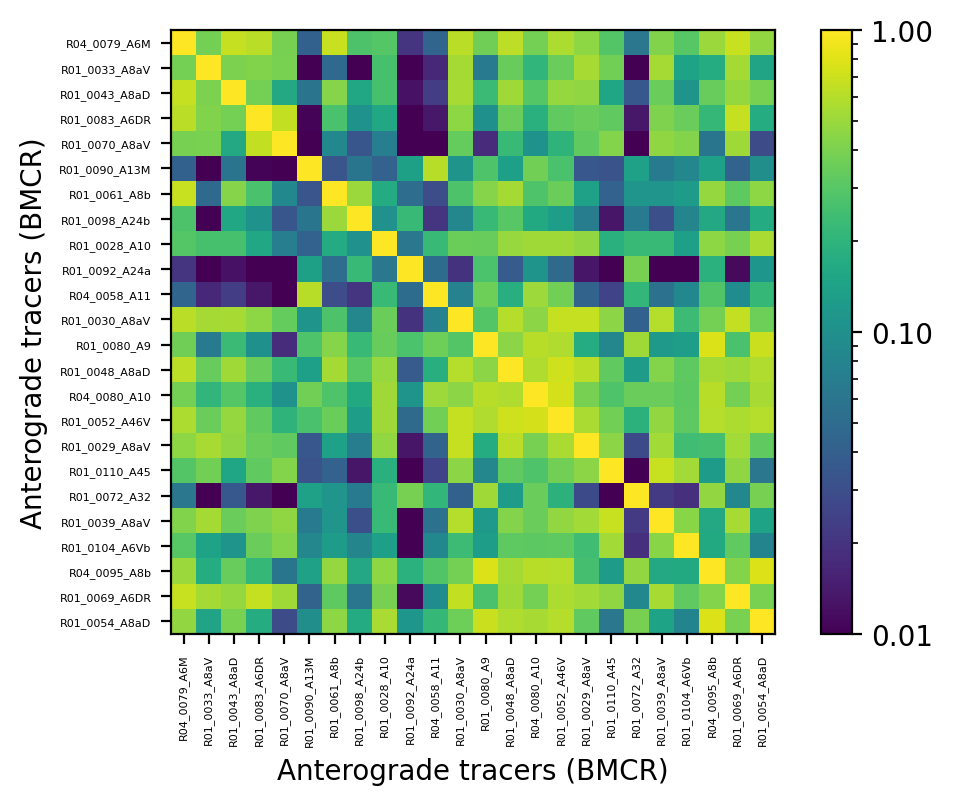

In [23]:
labels_x = [mids_r[best_retro[rsort[a]]]+"_"+rid_r[best_retro[rsort[a]]] for a in range(len(mids))]
_,indx = np.unique(labels_x, return_index=True)


mpl.rcParams['figure.dpi'] = 200
f = plt.figure()
ax = f.gca()


ax.imshow(cmat_rr[indx,:][:,indx], norm=LogNorm(vmin=0.01, vmax=1))

ax.set_xlabel("Retrograde tracers (Marmoset Brain Connectivity Atlas)")
ax.set_ylabel("Retrograde tracers (Marmoset Brain Connectivity Atlas)")

labels_x = [mids_r[best_retro[rsort[a]]]+"_"+rid_r[best_retro[rsort[a]]] for a in range(len(mids))]#[list(indx)]
labels_x = list(np.array(labels_x)[indx])
ax.set_xticks(ticks=np.arange(len(labels_x)), labels=labels_x,rotation = 90, fontsize=4)

ax.set_yticks(ticks=np.arange(len(labels_x)), labels=labels_x,rotation = 0, fontsize=4)

fmt = lambda x, pos: '{:.2f}'.format(x)
f.colorbar(im,ax=ax,format=FuncFormatter(fmt))
f.show()
f.savefig('BMCR_Figures/Fig07/MBCA_vs_MBCA_unique_NCC_logplot.pdf',bbox_inches='tight')  


mpl.rcParams['figure.dpi'] = 200
f = plt.figure()
ax = f.gca()

ax.imshow(cmat_aa[indx,:][:,indx], norm=LogNorm(vmin=0.01, vmax=1))

ax.set_xlabel("Anterograde tracers (BMCR)")
ax.set_ylabel("Anterograde tracers (BMCR)")

labels_x = [mids[rsort[a]]+"_"+rid_a[rsort[a]] for a in range(len(mids))]
labels_x = list(np.array(labels_x)[indx])
ax.set_xticks(ticks=np.arange(len(labels_x)), labels=labels_x,rotation = 90, fontsize=4)

ax.set_yticks(ticks=np.arange(len(labels_x)), labels=labels_x,rotation = 0, fontsize=4)

fmt = lambda x, pos: '{:.2f}'.format(x)
f.colorbar(im,ax=ax,format=FuncFormatter(fmt))        
f.show()
f.savefig('BMCR_Figures/Fig07/BMCR_vs_BMCR_unique_NCC_logplot.pdf',bbox_inches='tight')  

In [25]:
def random_permutation_test(A,B,reps,quiet = False):
    indeces = np.arange(A.shape[0])
    corr_p, _ = pearsonr(A,B)
    corr_s, _ = spearmanr(A,B)
    perms_p = []
    perms_s = []
    for r in range(reps):
        indeces = np.random.permutation(A.shape[0])
        C = B[indeces]
        corr_p_, _ = pearsonr(A,C)
        corr_s_, _ = spearmanr(A,C)
        perms_p += [corr_p_]
        perms_s += [corr_s_]
    perms_s = np.array(perms_s)
    perms_p = np.array(perms_p)
    perm_better_s = (np.abs(perms_s)>np.abs(corr_s)).sum()
    perm_better_p = (np.abs(perms_p)>np.abs(corr_p)).sum()
    
    p_value_p = 100*perm_better_s/reps
    p_value_s = 100*perm_better_p/reps
    if not quiet:
        print(p_value_p,"% (pearsonr ",corr_p,")")
        print(p_value_s,"% (spearmanr ",corr_s,")")
    return  p_value_p,p_value_s,corr_p,corr_s,perms_p,perms_s



cmat_aa2_unique = cmat_aa[indx,:][:,indx]
cmat_rr2_unique = cmat_rr[indx,:][:,indx]


mask = np.eye(cmat_aa2_unique.shape[0])==0
for a in range(cmat_aa2_unique.shape[0]):
    for b in range(a):
            mask[a,b] = 0
A = cmat_aa2_unique[mask].reshape([-1])
B = cmat_rr2_unique[mask].reshape([-1])

#p_value_p,p_value_s,corr_p,corr_s,perms_p,perms_s = random_permutation_test(A,B,reps=1000000)
p_value_p,p_value_s,corr_p,corr_s,perms_p,perms_s = random_permutation_test(A,B,reps=10000)

print("corr_p {} P {} corr_s {} P{}".format(corr_p,p_value_p,corr_s,p_value_s))

0.0 % (pearsonr  0.5659169816243554 )
0.0 % (spearmanr  0.6706656583096703 )
corr_p 0.5659169816243554 P 0.0 corr_s 0.6706656583096703 P0.0


In [29]:
atlas = nib.load(PATH_TO_BMCR_data+'/NORA-StackApp/Atlas/fstack_MBCA_annotations_MBM_nora.nii.gz').get_fdata()

atlas_fm = atlas[::2,::2,15,0]>0
atlas_fm = np.flip(np.rot90(atlas_fm),axis=1)


In [33]:

atlas_fm2 = np.abs(atlas[...,15,0]-np.roll(atlas[:,:,15,0],1,axis=0))>0
atlas_fm2 += np.abs(atlas[...,15,0]-np.roll(atlas[:,:,15,0],1,axis=1))>0
atlas_fm2 = (atlas_fm2[::2,::2]+atlas_fm2[1::2,::2]+atlas_fm2[::2,1::2]+atlas_fm2[1::2,1::2])
atlas_fm2 = np.flip(np.rot90(atlas_fm2),axis=1)


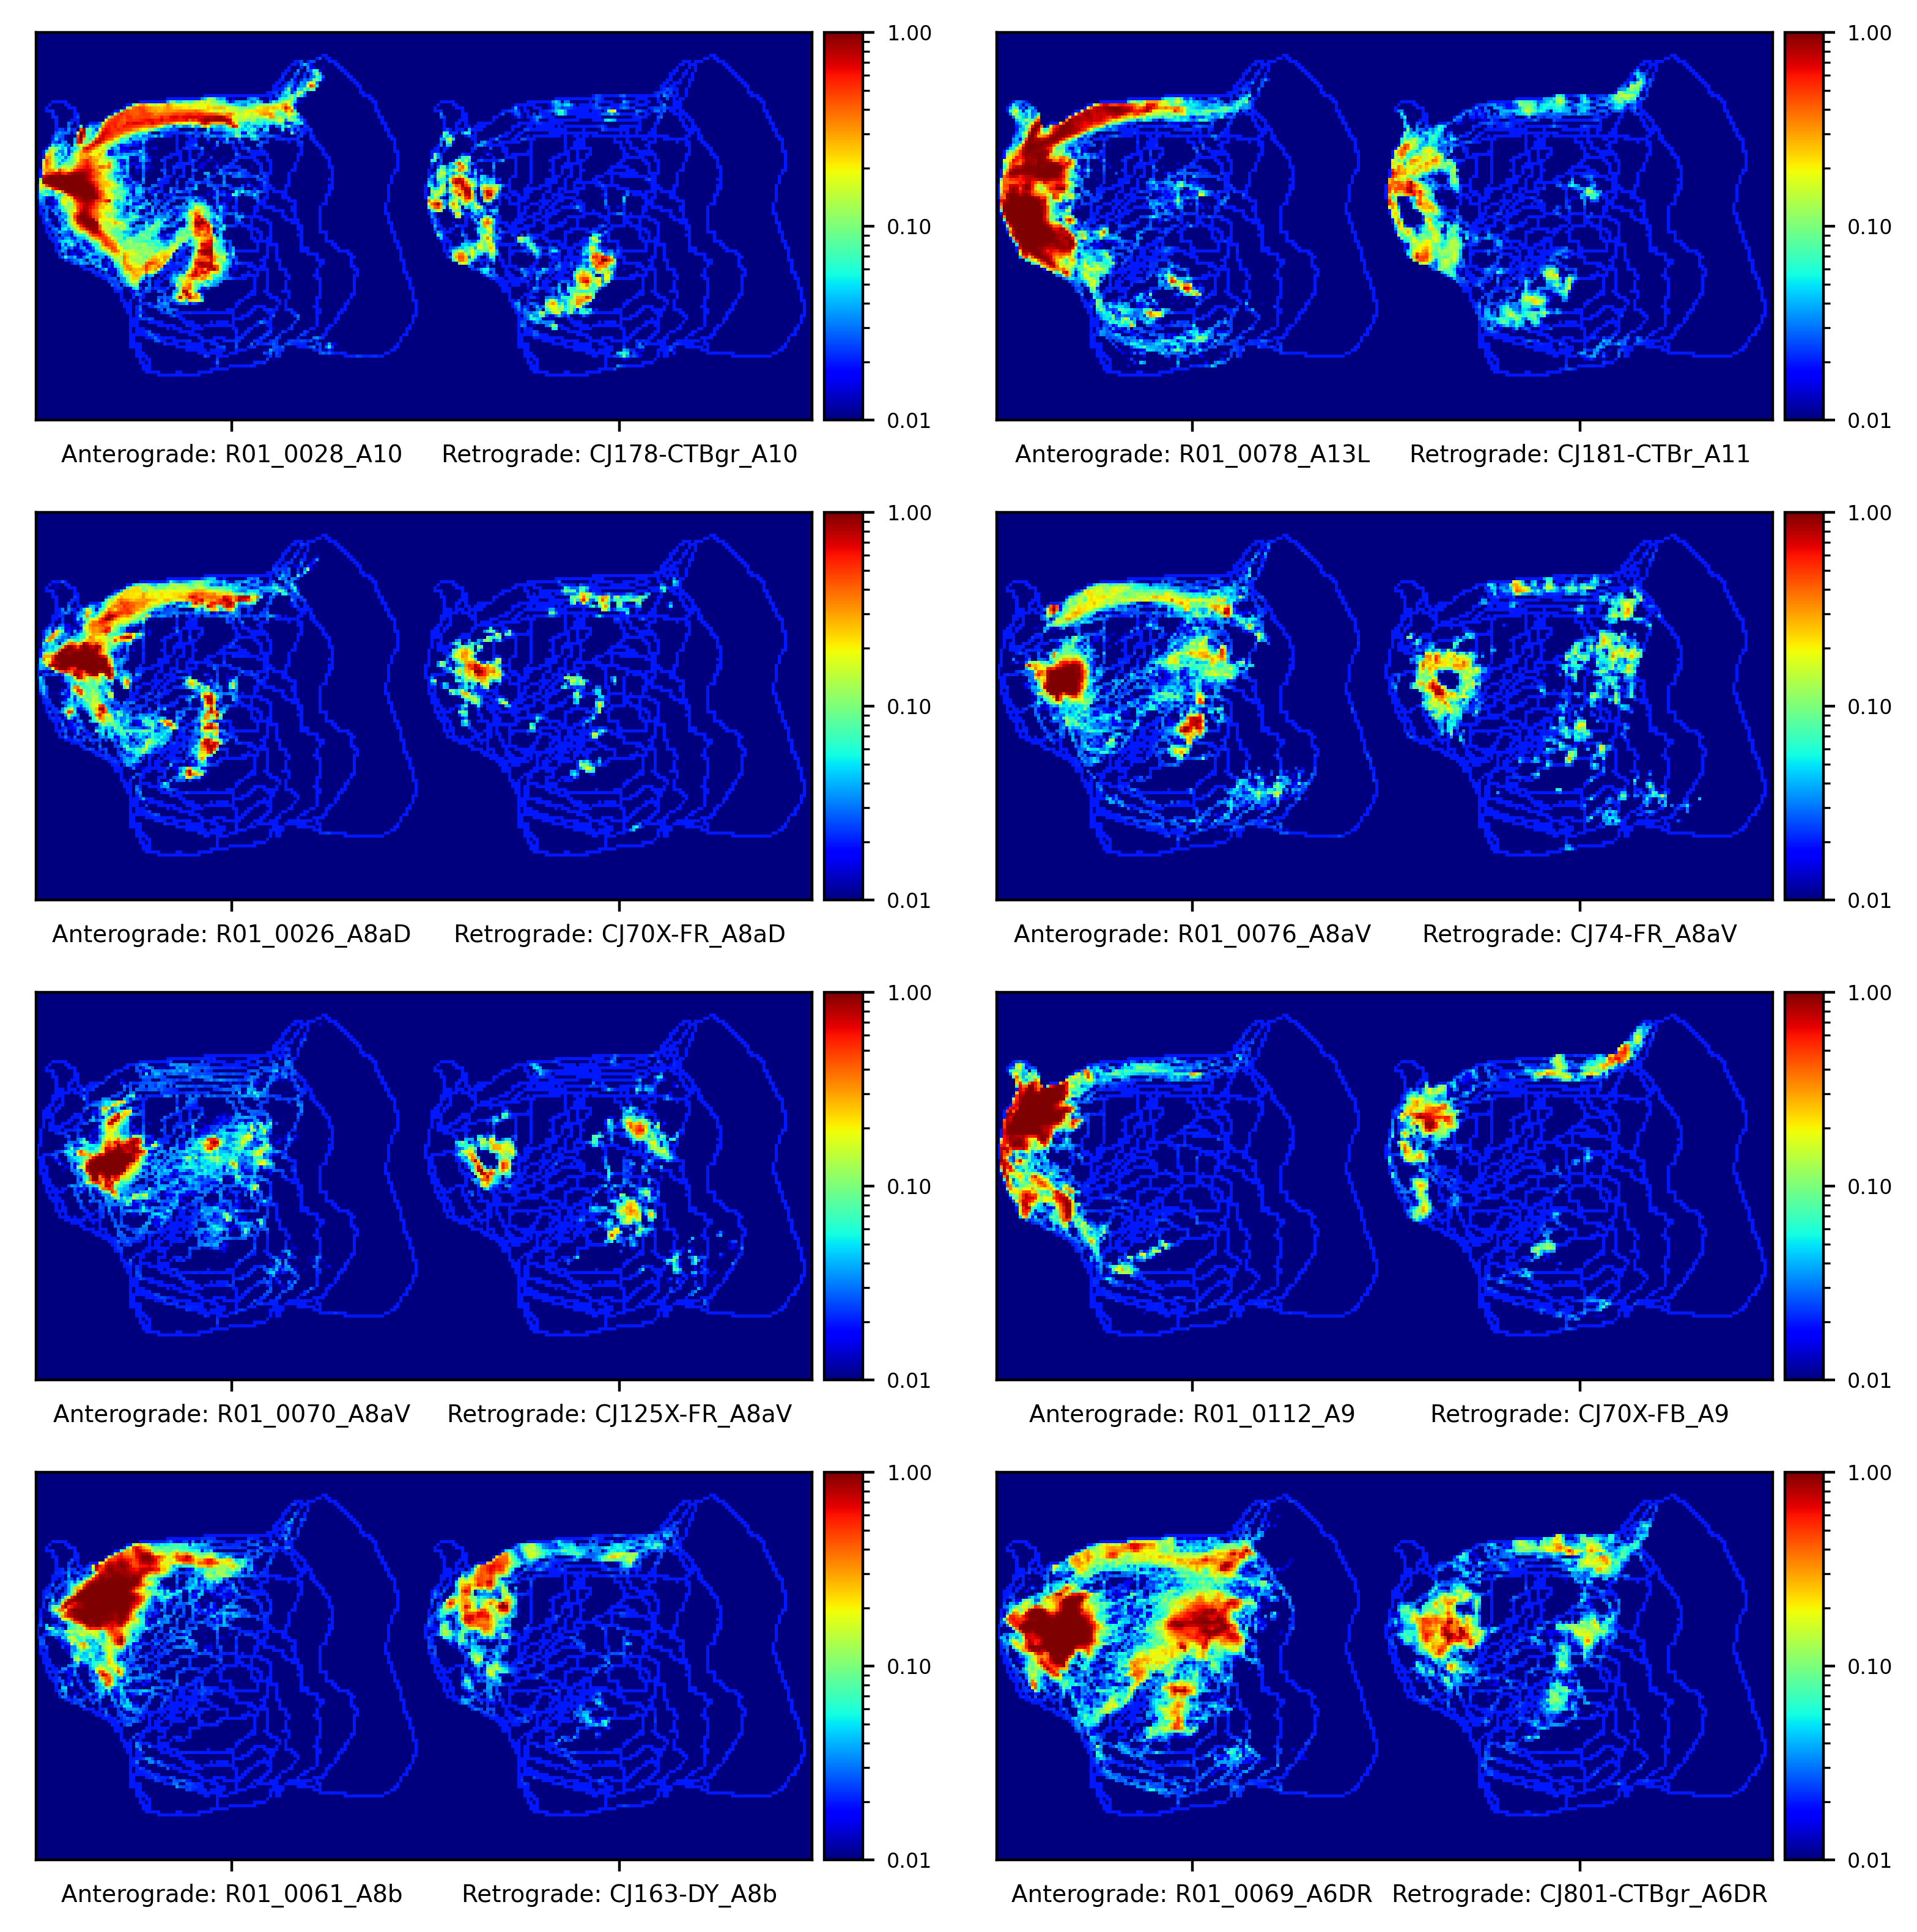

In [58]:
mpl.rcParams['figure.dpi'] = 400

labels_x = [mids_r[best_retro[rsort[a]]]+"_"+rid_r[best_retro[rsort[a]]] for a in range(len(mids))]
labels_y = [mids[rsort[a]]+"_"+rid_a[rsort[a]] for a in range(len(mids))]

mids_= ["_".join(m.split("_")[:2]) for m in labels_y]
ids = []
ids += [mids_.index("R01_0028")]
ids += [mids_.index("R01_0078")]
ids += [mids_.index("R01_0026")]
ids += [mids_.index("R01_0076")]
ids += [mids_.index("R01_0070")]
ids += [mids_.index("R01_0112")]
ids += [mids_.index("R01_0061")]
ids += [mids_.index("R01_0069")]
f, axes = plt.subplots(4,2, figsize=(8, 8))
    
count = 0
for xx in range(axes.shape[0]):
    for yy in range(axes.shape[1]):
        a = ids[count]
        ax = axes[xx,yy]
        count += 1


        sa = files_a[rsort[a]]*1
        sr = files_r[best_retro[rsort[a]]]*1
        sa = sa/sa.max()+0.0000001
        sr = sr/sr.max()+0.0000001

        sa = np.flip(np.rot90(sa),axis=1).max(axis=2)+atlas_fm2*0.02
        sr = np.flip(np.rot90(sr),axis=1).max(axis=2)+atlas_fm2*0.02

        both = np.concatenate((sa,sr),axis=1)



        ax.set_xticks(ticks=[125/2.0,125*(3/2.0)], labels=["Anterograde: "+labels_y[a],"Retrograde: "+labels_x[a]], fontsize=7)
        ax.get_yaxis().set_visible(False)
        
        im = ax.imshow(both, norm=LogNorm(vmin=0.01, vmax=1),cmap="jet")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        fmt = lambda x, pos: '{:.2f}'.format(x)
        cb = f.colorbar(im,ax=ax,format=FuncFormatter(fmt),cax=cax)  
        cb.ax.tick_params(labelsize=6) 
        #f.show()

f.tight_layout()         
f.show()

f.savefig('BMCR_Figures/Fig08/BMCA_vs_BMCA_similar_FMprojection.pdf',bbox_inches='tight')  
